<a href="https://colab.research.google.com/github/sunxueliang96/WF-FrameWork/blob/master/GAN_WF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount Google Drive as folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/'My Drive'/datasets/no_paded/close_world/knn

/content/drive/My Drive/datasets/no_paded/close_world/knn


In [3]:
ls

X_knnbatch.pkl  y_knnbatch.pkl


In [4]:
import pickle
from collections import Counter
import numpy as np
with open ('X_knnbatch.pkl','rb') as handle:
    X_train = np.array(pickle.load(handle,encoding='iso-8859-1'))
with open ('y_knnbatch.pkl','rb') as handle:
    y_train = np.array(pickle.load(handle,encoding='iso-8859-1'))

maxlen = 2000
NB_classes = len(Counter(y_train).keys())

print('Number of samples :' , X_train.shape[0])
print('Type of samples :' , NB_classes)
print('Average sequence length: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('maxlen setted as {}'.format(maxlen))

Number of samples : 9100
Type of samples : 100
Average sequence length: 1816
maxlen setted as 2000


In [5]:
from keras.preprocessing import sequence
from keras.utils import np_utils


X_train = sequence.pad_sequences(X_train,maxlen=maxlen,padding='post',truncating='post')

# append the N+1 class as fake 
y_train = np.append(y_train , NB_classes)
NB_classes = NB_classes + 1
print('the id of faker is {}'.format(NB_classes))
y_train = np_utils.to_categorical(y_train, NB_classes)


Using TensorFlow backend.


the id of faker is 101


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input, Lambda, Concatenate
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam


def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

NB_split = [None,100,50,25,10]       # that means 1%,2%,5%,10%
NB_generator_output = [None]

overhead = 100      #control the overhead rate here
print('the overhaed is {} %'.format(overhead))

overhead_split = overhead*maxlen//100//(len(NB_split)-1)

for split in NB_split[1:]:
    NB_output = overhead_split//split
    NB_generator_output.append(NB_output)

NB_generator_output



the overhaed is 100 %


[None, 5, 10, 20, 50]

In [29]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects


def custom_activation(x):
    return (K.sigmoid(x) * 2) - 1

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def create_generator():
    inputs_1  = Input(shape=(maxlen,))
    #block #1
    splits_1 = Lambda(lambda x: tf.split(x, num_or_size_splits=NB_split[1], axis=1))(inputs_1)       #tf.split int for number, vector for sizes
    branch_outputs_1 = []
    for i in range(NB_split[1]):
        x_1 = Dense(1024, activation='relu')(splits_1[i])   #single full connected layer for temporary
        x_1 = Dense(521, activation='relu')(x_1)   #single full connected layer for temporary
        x_1 = Dense(256, activation='relu')(x_1)   #single full connected layer for temporary
        x_1 = Dense(128, activation='relu')(x_1)   #single full connected layer for temporary
        x_1 = Dense(64, activation='relu')(x_1)   #single full connected layer for temporary
        outputs_noise_1 = Dense(NB_generator_output[1], activation=custom_activation)(x_1)
        outputs_noise_1 = Lambda(lambda x: tf.math.divide_no_nan(x,tf.abs(x)))(outputs_noise_1)
        outputs_concat_1 = keras.layers.concatenate([splits_1[i], outputs_noise_1])
        branch_outputs_1.append(outputs_concat_1)
    out_1 = Concatenate()(branch_outputs_1)

    #block #2
    splits_2 = Lambda(lambda x: tf.split(x, num_or_size_splits=NB_split[2], axis=1))(out_1)
    branch_outputs_2 = []
    for i in range(NB_split[2]):
        x_2 = Dense(1024, activation='relu')(splits_2[i])   #single full connected layer for temporary
        x_2 = Dense(521, activation='relu')(x_2)   #single full connected layer for temporary
        x_2 = Dense(256, activation='relu')(x_2)   #single full connected layer for temporary
        x_2 = Dense(128, activation='relu')(x_2)   #single full connected layer for temporary
        x_2 = Dense(64, activation='relu')(x_2)   #single full connected layer for temporary
        outputs_noise_2 = Dense(NB_generator_output[2], activation=custom_activation)(x_2)
        outputs_noise_2 = Lambda(lambda x: tf.math.divide_no_nan(x,tf.abs(x)))(outputs_noise_2)
        outputs_concat_2 = keras.layers.concatenate([splits_2[i], outputs_noise_2])
        branch_outputs_2.append(outputs_concat_2)
    out_2 = Concatenate()(branch_outputs_2)
    #block #3
    splits_3 = Lambda(lambda x: tf.split(x, num_or_size_splits=NB_split[3], axis=1))(out_2)
    branch_outputs_3 = []
    for i in range(NB_split[3]):
        x_3 = Dense(1024, activation='relu')(splits_3[i])   #single full connected layer for temporary
        x_3 = Dense(521, activation='relu')(x_3)   #single full connected layer for temporary
        x_3 = Dense(256, activation='relu')(x_3)   #single full connected layer for temporary
        x_3 = Dense(128, activation='relu')(x_3)   #single full connected layer for temporary
        x_3 = Dense(64, activation='relu')(x_3)   #single full connected layer for temporary
        outputs_noise_3 = Dense(NB_generator_output[3], activation=custom_activation)(x_3)
        outputs_noise_3 = Lambda(lambda x: tf.math.divide_no_nan(x,tf.abs(x)))(outputs_noise_3)
        outputs_concat_3 = keras.layers.concatenate([splits_3[i], outputs_noise_3])
        branch_outputs_3.append(outputs_concat_3)
    out_3 = Concatenate()(branch_outputs_3)

    #block #4
    splits_4 = Lambda(lambda x: tf.split(x, num_or_size_splits=NB_split[4], axis=1))(out_3)
    branch_outputs_4 = []
    for i in range(NB_split[4]):
        x_4 = Dense(1024, activation='relu')(splits_4[i])   #single full connected layer for temporary
        x_4 = Dense(521, activation='relu')(x_4)   #single full connected layer for temporary
        x_4 = Dense(256, activation='relu')(x_4)   #single full connected layer for temporary
        x_4 = Dense(128, activation='relu')(x_4)   #single full connected layer for temporary
        x_4 = Dense(64, activation='relu')(x_4)   #single full connected layer for temporary
        outputs_noise_4 = Dense(NB_generator_output[4], activation=custom_activation)(x_4)
        outputs_noise_4 = Lambda(lambda x: tf.math.divide_no_nan(x,tf.abs(x)))(outputs_noise_4)
        outputs_concat_4 = keras.layers.concatenate([splits_4[i], outputs_noise_4])
        branch_outputs_4.append(outputs_concat_4)
    out_4 = Concatenate()(branch_outputs_4)

    generator = Model(inputs=inputs_1, outputs=out_4)    
    generator.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return generator
    
g=create_generator()
NB_output  = g.layers[-1].output_shape[-1]
g.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
lambda_742 (Lambda)             [(None, 20), (None,  0           input_12[0][0]                   
__________________________________________________________________________________________________
dense_1500 (Dense)              (None, 1024)         21504       lambda_742[0][0]                 
__________________________________________________________________________________________________
dense_1506 (Dense)              (None, 1024)         21504       lambda_742[0][1]                 
___________________________________________________________________________________________

In [30]:
def create_discriminator(input_dim=NB_output):
    discriminator=Sequential()
    inputs = Input(shape=(input_dim,))
    x = Dense(512, activation='relu')(inputs)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(units=NB_classes, activation='softmax')(x)
    discriminator = Model(inputs=inputs,outputs=outputs)
    discriminator.compile(loss='categorical_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 4000)              0         
_________________________________________________________________
dense_2610 (Dense)           (None, 512)               2048512   
_________________________________________________________________
dense_2611 (Dense)           (None, 1024)              525312    
_________________________________________________________________
dense_2612 (Dense)           (None, 512)               524800    
_________________________________________________________________
dense_2613 (Dense)           (None, 128)               65664     
_________________________________________________________________
dense_2614 (Dense)           (None, 101)               13029     
Total params: 3,177,317
Trainable params: 3,177,317
Non-trainable params: 0
________________________________________________

In [0]:
from keras import backend as K

def mycrossentropy(y_true, y_pred):
    loss = K.categorical_crossentropy(y_true, y_pred)
    return 1/loss                 # the more error the lower loss
    
def categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0):
    y_pred = K.constant(y_pred) if not K.is_tensor(y_pred) else y_pred
    y_true = K.cast(y_true, y_pred.dtype)
    if label_smoothing is not 0:
        smoothing = K.cast_to_floatx(label_smoothing)
        def _smooth_labels():
            num_classes = K.cast(K.shape(y_true)[1], y_pred.dtype)
            return y_true * (1.0 - smoothing) + (smoothing / num_classes)
        y_true = K.switch(K.greater(smoothing, 0), _smooth_labels, lambda: y_true)
    return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)

In [32]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(maxlen,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss=mycrossentropy, optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 2000)              0         
_________________________________________________________________
model_11 (Model)             (None, 4000)              142713105 
_________________________________________________________________
model_12 (Model)             (None, 101)               3177317   
Total params: 145,890,422
Trainable params: 142,713,105
Non-trainable params: 3,177,317
_________________________________________________________________


In [33]:
from tqdm import tqdm
dis_loss = []
gan_loss = []
generator= create_generator()
discriminator= create_discriminator()
gan = create_gan(discriminator, generator)

def training(NB_epochs=300, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    print('Number of batches {}'.format(batch_count))

    #valid = np.ones((batch_size, 1))  # real is 111111111111111111111111
    #fake = np.ones((batch_size, NB_classes))  # fake is 00000000000000000000000000
    fake = []

    for i in range(batch_size):
        fake.append(y_train[-1])
    fake = np.array(fake) 

    for epoch in tqdm(range(NB_epochs)):
        for _ in range(batch_count):
            #  Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)        # Select a random batch of sequences
            seqs = X_train[idx]
            y = y_train[idx]

            discriminator.trainable=True
            gen_seqs = generator.predict(seqs)    #  Generate a batch of new seqs
            seqs = sequence.pad_sequences(seqs,maxlen=NB_output,padding='post',truncating='post')
            d_loss_real = discriminator.train_on_batch(seqs,y)
            d_loss_fake = discriminator.train_on_batch(gen_seqs,fake)
            d_loss = 0.5*np.add(d_loss_real,d_loss_fake)
            dis_loss.append(d_loss)

            #  Train Generator
            seqs = sequence.pad_sequences(seqs,maxlen=maxlen,padding='post',truncating='post')
            discriminator.trainable=False
            g_loss = gan.train_on_batch(seqs,y)
            gan_loss.append(g_loss)
            #if epoch in range(0,NB_epochs,NB_epochs//10):
              #  print ('dis:{}gan{}'.format(d_loss_real,g_loss))
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
training(NB_epochs=10, batch_size=128)



  0%|          | 0/10 [00:00<?, ?it/s]

Number of batches 71



100%|██████████| 10/10 [17:20<00:00, 85.97s/it]


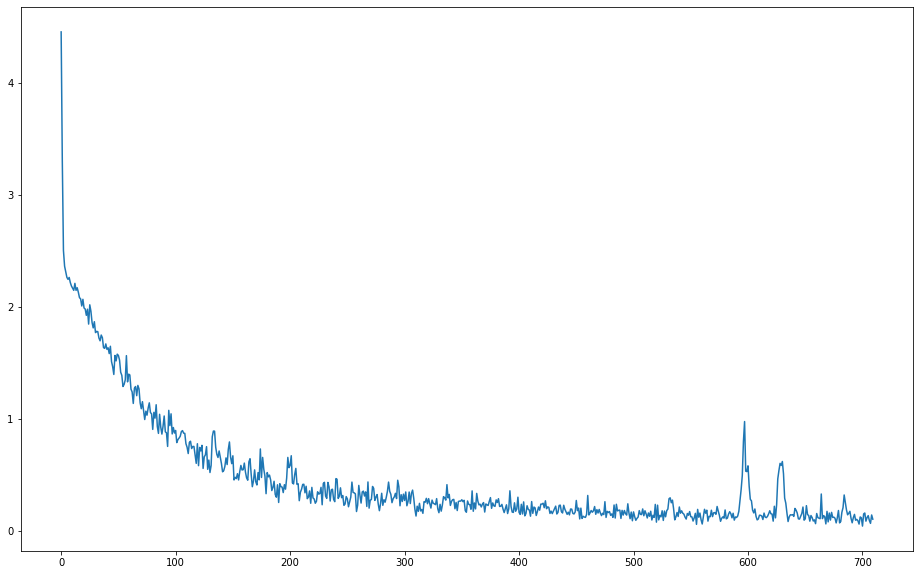

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(dis_loss)


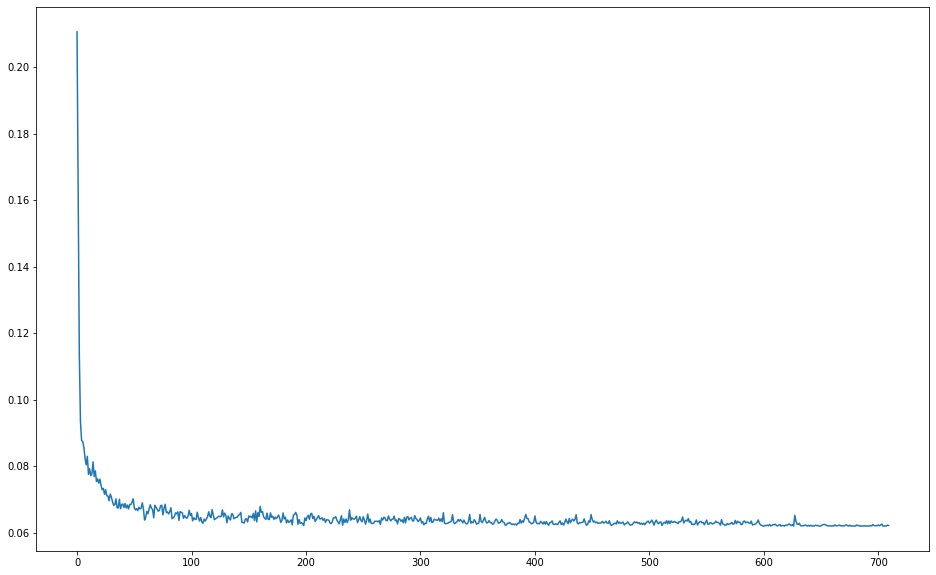

In [35]:
plt.figure(figsize=(16,10))
plt.plot(gan_loss)

In [0]:
#CNN
from keras import Input,Model,Sequential
from keras.layers import Embedding,GlobalAveragePooling1D,Dense,Dropout
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform
from keras.optimizers import Adamax
def CNN(input_shape, classes):
    model = Sequential()
    #Block1
    filter_num = ['None',32,64,128,256]
    kernel_size = ['None',8,8,8,8]
    conv_stride_size = ['None',1,1,1,1]
    pool_stride_size = ['None',4,4,4,4]
    pool_size = ['None',8,8,8,8]

    model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=(input_shape,1),
                      strides=conv_stride_size[1], padding='same',
                      name='block1_conv1'))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU(alpha=1.0, name='block1_adv_act1'))
    model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1],
                      strides=conv_stride_size[1], padding='same',
                      name='block1_conv2'))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU(alpha=1.0, name='block1_adv_act2'))
    model.add(MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                            padding='same', name='block1_pool'))
    model.add(Dropout(0.1, name='block1_dropout'))

    model.add(Conv1D(filters=filter_num[2], kernel_size=kernel_size[2],
                      strides=conv_stride_size[2], padding='same',
                      name='block2_conv1'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block2_act1'))

    model.add(Conv1D(filters=filter_num[2], kernel_size=kernel_size[2],
                      strides=conv_stride_size[2], padding='same',
                      name='block2_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block2_act2'))
    model.add(MaxPooling1D(pool_size=pool_size[2], strides=pool_stride_size[3],
                            padding='same', name='block2_pool'))
    model.add(Dropout(0.1, name='block2_dropout'))

    model.add(Conv1D(filters=filter_num[3], kernel_size=kernel_size[3],
                      strides=conv_stride_size[3], padding='same',
                      name='block3_conv1'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block3_act1'))
    model.add(Conv1D(filters=filter_num[3], kernel_size=kernel_size[3],
                      strides=conv_stride_size[3], padding='same',
                      name='block3_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block3_act2'))
    model.add(MaxPooling1D(pool_size=pool_size[3], strides=pool_stride_size[3],
                            padding='same', name='block3_pool'))
    model.add(Dropout(0.1, name='block3_dropout'))

    model.add(Conv1D(filters=filter_num[4], kernel_size=kernel_size[4],
                      strides=conv_stride_size[4], padding='same',
                      name='block4_conv1'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block4_act1'))
    model.add(Conv1D(filters=filter_num[4], kernel_size=kernel_size[4],
                      strides=conv_stride_size[4], padding='same',
                      name='block4_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='block4_act2'))
    model.add(MaxPooling1D(pool_size=pool_size[4], strides=pool_stride_size[4],
                            padding='same', name='block4_pool'))
    model.add(Dropout(0.1, name='block4_dropout'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(512, kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='fc1_act'))

    model.add(Dropout(0.7, name='fc1_dropout'))

    model.add(Dense(512, kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(BatchNormalization())
    model.add(Activation('relu', name='fc2_act'))

    model.add(Dropout(0.5, name='fc2_dropout'))

    model.add(Dense(classes, kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    model.add(Activation('softmax', name="softmax"))
    return model

In [0]:
import keras
from keras import backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
 
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [38]:
from sklearn.model_selection import train_test_split
with open ('X_knnbatch.pkl','rb') as handle:
    X_test = np.array(pickle.load(handle,encoding='iso-8859-1'))
with open ('y_knnbatch.pkl','rb') as handle:
    y_test = np.array(pickle.load(handle,encoding='iso-8859-1'))
X_train_saved,X_test_saved,y_train_saved,y_test_saved = train_test_split(X_test,y_test,test_size=0.3)

X_train_saved = sequence.pad_sequences(X_train_saved,maxlen=maxlen,padding='post',truncating='post')
X_test_saved = sequence.pad_sequences(X_test_saved,maxlen=maxlen,padding='post',truncating='post')
X_train_saved = X_train_saved[:,:,np.newaxis]
X_test_saved = X_test_saved[:,:,np.newaxis]
y_train_saved = np_utils.to_categorical(y_train_saved, NB_classes-1)
y_test_saved = np_utils.to_categorical(y_test_saved, NB_classes-1)

model_CNN_org = CNN(maxlen,NB_classes-1)
model_CNN_org.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','top_k_categorical_accuracy', precision, recall, fmeasure])

history_CNN_org = model_CNN_org.fit(X_train_saved,y_train_saved,batch_size=128,epochs=30,validation_data=(X_test_saved,y_test_saved),verbose=0)

In [39]:
from sklearn.model_selection import train_test_split
with open ('X_knnbatch.pkl','rb') as handle:
    X_test = np.array(pickle.load(handle,encoding='iso-8859-1'))
with open ('y_knnbatch.pkl','rb') as handle:
    y_test = np.array(pickle.load(handle,encoding='iso-8859-1'))

X_test = sequence.pad_sequences(X_test,maxlen=maxlen,padding='post',truncating='post')
X_test = generator.predict(X_test)
X_train_saved,X_test_saved,y_train_saved,y_test_saved = train_test_split(X_test,y_test,test_size=0.3)


X_train_saved = X_train_saved[:,:,np.newaxis]
X_test_saved = X_test_saved[:,:,np.newaxis]
y_train_saved = np_utils.to_categorical(y_train_saved, NB_classes-1)
y_test_saved = np_utils.to_categorical(y_test_saved, NB_classes-1)

model_CNN_after = CNN(NB_output,NB_classes-1)
model_CNN_after.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','top_k_categorical_accuracy', precision, recall, fmeasure])

history_CNN_after = model_CNN_after.fit(X_train_saved,y_train_saved,batch_size=128,epochs=30,validation_data=(X_test_saved,y_test_saved),verbose=0)

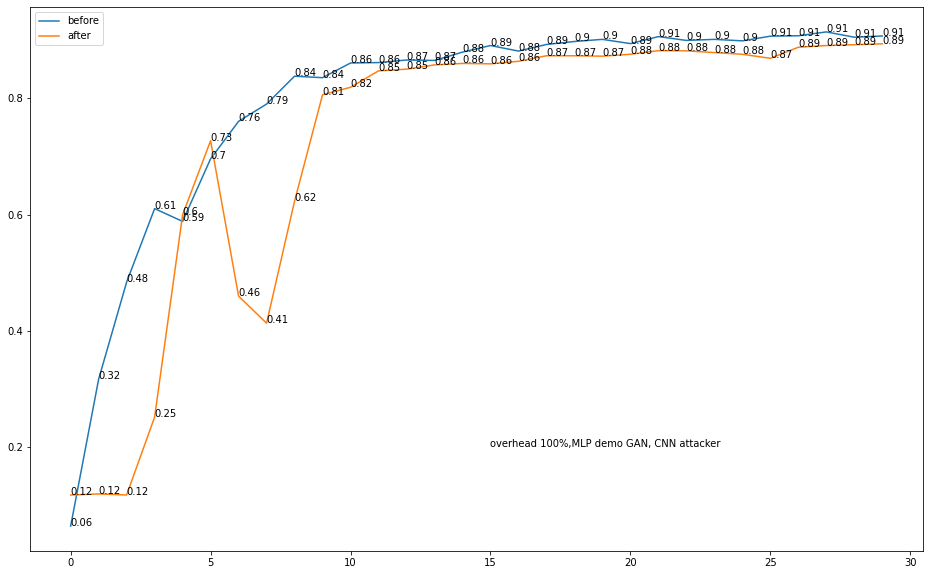

In [40]:
plt.figure(figsize=(16,10))
plt.plot(history_CNN_org.history['val_acc'],label = 'before')
[plt.annotate(round(history_CNN_org.history['val_acc'][i],2),(i,history_CNN_org.history['val_acc'][i])) for i in range(len(history_CNN_org.history['val_acc']))]
plt.plot(history_CNN_after.history['val_acc'],label = 'after')
[plt.annotate(round(history_CNN_after.history['val_acc'][i],2),(i,history_CNN_after.history['val_acc'][i])) for i in range(len(history_CNN_after.history['val_acc']))]
plt.annotate('overhead 100%,MLP demo GAN, CNN attacker',(15,0.2))
plt.legend()
plt.show()

In [0]:

#MLP
from keras import Sequential
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.optimizers import Adamax
def MLP(input_shape,classes):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_shape,)))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    return model

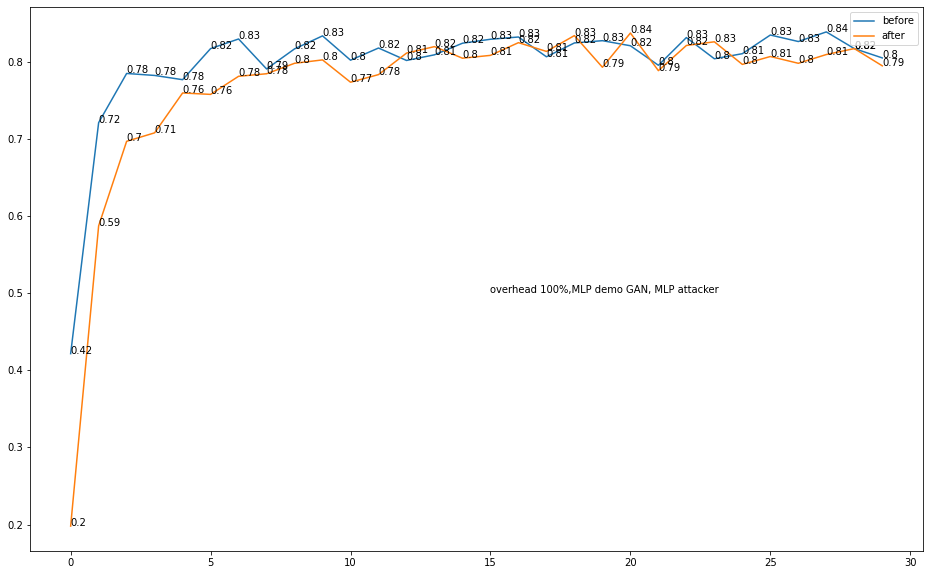

In [42]:
from sklearn.model_selection import train_test_split
with open ('X_knnbatch.pkl','rb') as handle:
    X_test = np.array(pickle.load(handle,encoding='iso-8859-1'))
with open ('y_knnbatch.pkl','rb') as handle:
    y_test = np.array(pickle.load(handle,encoding='iso-8859-1'))
X_train_saved,X_test_saved,y_train_saved,y_test_saved = train_test_split(X_test,y_test,test_size=0.3)

X_train_saved = sequence.pad_sequences(X_train_saved,maxlen=maxlen,padding='post',truncating='post')
X_test_saved = sequence.pad_sequences(X_test_saved,maxlen=maxlen,padding='post',truncating='post')
y_train_saved = np_utils.to_categorical(y_train_saved, NB_classes-1)
y_test_saved = np_utils.to_categorical(y_test_saved, NB_classes-1)

model_MLP_org = MLP(maxlen,NB_classes-1)
model_MLP_org.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','top_k_categorical_accuracy', precision, recall, fmeasure])

history_MLP_org = model_MLP_org.fit(X_train_saved,y_train_saved,batch_size=128,epochs=30,validation_data=(X_test_saved,y_test_saved),verbose=0)

from sklearn.model_selection import train_test_split
with open ('X_knnbatch.pkl','rb') as handle:
    X_test = np.array(pickle.load(handle,encoding='iso-8859-1'))
with open ('y_knnbatch.pkl','rb') as handle:
    y_test = np.array(pickle.load(handle,encoding='iso-8859-1'))

X_test = sequence.pad_sequences(X_test,maxlen=maxlen,padding='post',truncating='post')
X_test = generator.predict(X_test)
X_train_saved,X_test_saved,y_train_saved,y_test_saved = train_test_split(X_test,y_test,test_size=0.3)

y_train_saved = np_utils.to_categorical(y_train_saved, NB_classes-1)
y_test_saved = np_utils.to_categorical(y_test_saved, NB_classes-1)

model_MLP_after = MLP(NB_output,NB_classes-1)
model_MLP_after.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','top_k_categorical_accuracy', precision, recall, fmeasure])

history_MLP_after = model_MLP_after.fit(X_train_saved,y_train_saved,batch_size=128,epochs=30,validation_data=(X_test_saved,y_test_saved),verbose=0)




plt.figure(figsize=(16,10))
plt.plot(history_MLP_org.history['val_acc'],label = 'before')
[plt.annotate(round(history_MLP_org.history['val_acc'][i],2),(i,history_MLP_org.history['val_acc'][i])) for i in range(len(history_MLP_org.history['val_acc']))]
plt.plot(history_MLP_after.history['val_acc'],label = 'after')
[plt.annotate(round(history_MLP_after.history['val_acc'][i],2),(i,history_MLP_after.history['val_acc'][i])) for i in range(len(history_MLP_after.history['val_acc']))]
plt.annotate('overhead 100%,MLP demo GAN, MLP attacker',(15,0.5))
plt.legend()
plt.show()